In [1]:
from symreg import Regressor
import pandas as pd
import numpy as np
import random
import traceback

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
diff_data, duration_per = 600, 3 # 30 minutes
# diff_data, duration_per = 180, 3 # 15 minutes
# diff_data, duration_per = 120, 1.8 # 3.6 minutes
# diff_data, duration_per   = 30, 3 # instant

X, y = load_boston(return_X_y=True)
X /= X.mean()
y /= y.mean()
X, Xt, y, yt = train_test_split(X, y, test_size=0.4, random_state=0)

results = []

def time_left(diff_data):
    return f'{diff_data * duration_per / 60} minutes'

print(f'Will take {time_left(diff_data)}')

def eval_settings(**settings):
    r = Regressor(verbose=True, duration=duration_per, **settings)
    r.fit(X, y)
    
    y_out = r.predict(Xt, max_complexity=10)
    error = np.median((yt - y_out) ** 2)
    return {**settings, **{'error': error}}


for i in range(diff_data):
    random.seed(i)
    try:
        args = {
#             'mutation_children': random.choice([0, 1, 2, 3, 4, 5]),
#             'crossover_children': random.choice([0, 1, 2, 3, 4, 5]),
            'simplify_chance': random.random()*.05 + .06,
        }

        results.append(eval_settings(**args))
        print(results[-1])
        print('------------', time_left(diff_data - i-1), 'left')
    except ValueError as e:
        print('------------', 'Value Error for seed', i, ': ', args)
        traceback.print_exc()


Will take 1.0 minutes
Time left  : 1.98s
Best so far: (0.2215583087143844, 150) (error, complexity)
Time left  : 0.97s
Best so far: (0.21060594470535846, 71) (error, complexity)
Complete. {'generations': 142, 'stagnated_generations': 2, 'duration': 3.0360569953918457}
{'simplify_chance': 0.1022210925762524, 'error': 0.01637658396698121}
------------ 0.95 minutes left
Time left  : 1.98s
Best so far: (0.22144102246490224, 33) (error, complexity)
Time left  : 0.97s
Best so far: (0.21926389235098753, 50) (error, complexity)
Time left  : -0.03s
Best so far: (0.21694021148463047, 92) (error, complexity)
Complete. {'generations': 178, 'stagnated_generations': 0, 'duration': 3.0562963485717773}
{'simplify_chance': 0.06671821220562006, 'error': 0.018926714144871168}
------------ 0.9 minutes left
Time left  : 1.98s
Best so far: (0.22680688329796866, 40) (error, complexity)
Time left  : 0.97s
Best so far: (0.20430307939217673, 20) (error, complexity)
Complete. {'generations': 224, 'stagnated_gene

In [3]:
pd.DataFrame(results).sort_values('error').to_csv('metaopt.tsv', sep='\t', index=False)

In [4]:
resdf = pd.read_csv('metaopt.tsv', sep='\t').sort_values('error').dropna()

split = list(map(int, np.linspace(0, 100, 6)[1:]))
percs = [s/100 for s in split]
names = [f'{s}%' for s in split]
percentiles = resdf['error'].describe(percentiles=percs).loc[names]
print(names)
resdf['chunk'] = 0
for p in percentiles:
    resdf.loc[resdf['error'] > p, 'chunk'] += 1

final_res = pd.concat([resdf.groupby('chunk').mean(), resdf.groupby('chunk').count()['error']], axis=1)
final_res

['20%', '40%', '60%', '80%', '100%']


,simplify_chance,error,error
chunk,,,
0,0.085777,0.012873,4
1,0.088004,0.015367,4
2,0.078064,0.019886,4
3,0.082644,0.025561,4
4,0.083134,0.034638,4


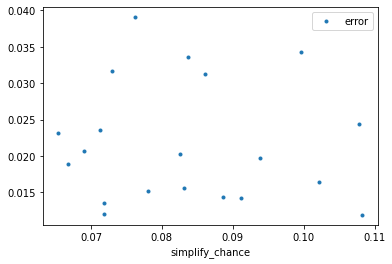

In [5]:
resdf[['simplify_chance', 'error']].plot(x='simplify_chance', style='.')

,simplify_chance
chunk,
0,0.085777
1,0.088004
2,0.078064
3,0.082644
4,0.083134


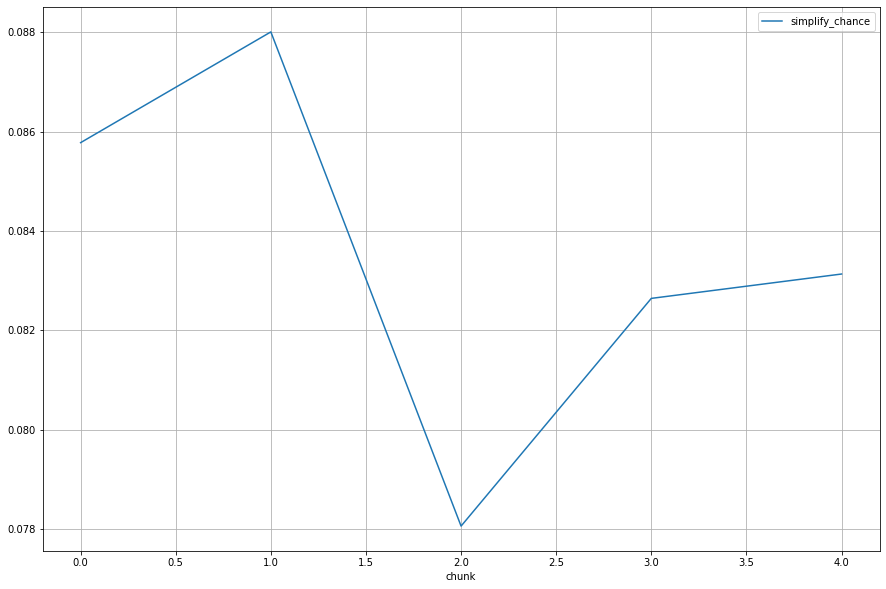

In [6]:
noerror = final_res.iloc[:, :-2]
noerror.plot(figsize=(15, 10), grid=True)
noerror

In [7]:
final_res.iloc[:, :-1].corr('spearman')

,simplify_chance,error
simplify_chance,1.0,-0.5
error,-0.5,1.0


In [8]:
r2 = Regressor(duration=3, verbose=True)
X = resdf.iloc[:,  :-2]
y = resdf.iloc[:, -2]
X['rand'] = np.random.random(np.shape(X.iloc[:, 0]))
X['rand2'] = np.random.random(np.shape(X.iloc[:, 0]))
X /= X.mean()
y /= y.mean()

In [9]:
r2.fit(X, y)

Time left  : 1.98s
Best so far: (0.3523610805429846, 40) (error, complexity)
Time left  : 0.97s
Best so far: (0.35033061245693825, 77) (error, complexity)
Complete. {'generations': 129, 'stagnated_generations': 0, 'duration': 3.0601139068603516}


In [10]:
"""
[{'error': 0.0028049765715300722,
  'complexity': 1,
  'program': Program('0.014426645859910924', 3)},
"""

r2.results()

[{'error': 0.3714563980377167, 'complexity': 1, 'program': Program('1.0', 3)},
 {'error': 0.3591081643643425,
  'complexity': 3,
  'program': Program('pow $rand2 -0.19450914466422997', 3)},
 {'error': 0.3590638235232123,
  'complexity': 5,
  'program': Program('pow pow $rand2 $simplify_chance -0.19450914466422997', 3)},
 {'error': 0.35840768707675896,
  'complexity': 7,
  'program': Program('pow div 0.8971371122067768 $rand2 pow 3.594424599838792 -1.4851026398887537', 3)},
 {'error': 0.3577614089858522,
  'complexity': 9,
  'program': Program('pow div pow 2.0 -0.19450914466422997 $rand2 pow 3.0 -1.4851026398887537', 3)},
 {'error': 0.35685569680237583,
  'complexity': 14,
  'program': Program('pow rec $rand2 pow 2.0 mul -2.7057731348217797 pow pow pow 1.1089527548119864 -1.252253379280373 $rand2 $rand2', 3)},
 {'error': 0.3567969781309421,
  'complexity': 16,
  'program': Program('div pow rec $rand2 pow 2.0 mul -2.7057731348217797 pow pow pow 1.1089527548119864 -1.252253379280373 $rand

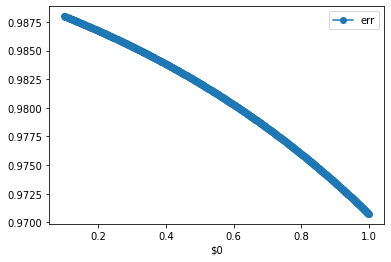

In [11]:
X = pd.DataFrame({'$0': np.linspace(0, 1, 1001)})
from symreg.ga import Program
p = Program(
    'pow 0.9891326826234386 exp $simplify_chance'
    .replace('$simplify_chance', '$0')
)
X['err'] = p.eval([X['$0']])
X[100:].plot(x='$0', y='err', marker='o')

We chose `mutation_children` to be 1 in production. It seems the other arguments do not matter - the error is very close to the constant program (complexity 1).